Implements algorithm 3 (ModMod) from Algorithms for "Approx Min of the Difference Between Submodular Fncs with Applications."

For prob_ssm

In [10]:
import torch
from torch import distributions as dist

import itertools
import pickle
import operator
import importlib

import random
import math
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
sns.set_context('paper')
# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'axes.labelsize': 35})
plt.rcParams.update({'legend.fontsize': 30})
plt.rcParams.update({'axes.titlesize': 16})

from gptorch import kernels, models

import helpers, opt, bases

In [2]:
with open('../inputs/phoq.pkl', 'rb') as f:
    t = pickle.load(f)

X = t[0] # one-hot encoding of X
T = t[1] # tokenized encoding of X
y = t[2].values

In [3]:
wt = helpers.decode_X(X[150614])  # wt as string
aas = 'ARNDCQEGHILKMFPSTWYV'

In [4]:
seq_to_x = {}
for i, x in enumerate(X):
    seq = helpers.decode_X(x)
    seq_to_x[seq] = i

In [29]:
singles = [wt[:i] + aas[j] + wt[i+1:] for i in range(4) for j in range(20)]
train_seqs = [wt] + singles
train_inds = [seq_to_x[seq] for seq in train_seqs]
np.random.seed(100)
train_inds += list(np.random.choice(len(X), 100, replace=True)) # generate random indices for 100 X's to sample from

X_train = X[train_inds]
y_train = y[train_inds]
X_test = X
y_true = y

In [6]:
ground = [(aa, i) for aa in aas for i in range(4)]

In [8]:
def seqs_from_set(chosen, L):
    pos = [[c[0] for c in chosen if c[1] == p] for p in range(L)]
    return [''.join(s) for s in itertools.product(*pos)]

In [30]:
helpers = importlib.reload(helpers)
opt = importlib.reload(opt)

rounds = 4
L = 4
n = 100

observed_inds = [train_inds]
X_sampled = [X[train_inds]]
y_sampled = [y[train_inds]]


libraries = []
histories = []

for rou in range(rounds):
    print('Round %d' %rou)
    inds = sorted(set(itertools.chain(*observed_inds)))
    dic, _ = helpers.get_predictions(X[inds], y[inds], X_test, its=500)
    print()
    seed = helpers.get_seed(dic)
    center, obj = bases.greedy(dic, seed, n, L)
    chosen, h = opt.mod_mod(ground, opt.obj_LHS, opt.obj_RHS, center, 
                       fn_args=(L, dic), g_args=(L, dic, n), verbose=True)
    libraries.append(chosen)
    histories.append(h)
    seqs = seqs_from_set(chosen, L)
    inds = np.random.choice(len(seqs), n, replace=True)
    sampled_seqs = [seqs[i] for i in inds]
    inds = [seq_to_x[s] for s in sampled_seqs]
    X_sampled.append(X[inds])
    y_sampled.append(y[inds])
    observed_inds.append(inds)
    
    

Round 0
Iteration 500 of 500	NLML: 37.3494	sn: 0.165943	
Iteration 0	 obj = -20.486116	
Iteration 1	 obj = -20.486115
Iteration 2	 obj = -20.486115
Round 1
Iteration 500 of 500	NLML: 2.7113	sn: 0.480295		
Iteration 0	 obj = -17.864445	
Iteration 1	 obj = -17.864449
Iteration 2	 obj = -17.864449
Round 2
Iteration 500 of 500	NLML: -11.5406	sn: 0.472299	
Iteration 0	 obj = -15.724091	
Iteration 1	 obj = -15.724092
Iteration 2	 obj = -15.724094
Iteration 3	 obj = -15.724092
Iteration 4	 obj = -15.724092
Round 3
Iteration 500 of 500	NLML: -20.3149	sn: 0.467085	
Iteration 0	 obj = -15.576752	
Iteration 1	 obj = -15.576748
Iteration 2	 obj = -15.576746
Iteration 3	 obj = -15.576748
Iteration 4	 obj = -15.576746
Iteration 5	 obj = -15.576752
Iteration 6	 obj = -15.576748
Iteration 7	 obj = -15.576748


In [31]:
libraries

[[('T', 0),
  ('S', 0),
  ('R', 1),
  ('S', 1),
  ('D', 1),
  ('T', 1),
  ('Q', 1),
  ('S', 2),
  ('R', 2),
  ('S', 3),
  ('T', 3),
  ('W', 3),
  ('L', 3),
  ('Q', 3),
  ('I', 3),
  ('Y', 3),
  ('E', 3),
  ('K', 3)],
 [('T', 0),
  ('S', 0),
  ('S', 1),
  ('D', 1),
  ('T', 1),
  ('R', 1),
  ('Q', 1),
  ('S', 2),
  ('R', 2),
  ('W', 3),
  ('S', 3),
  ('L', 3),
  ('Q', 3),
  ('I', 3),
  ('K', 3),
  ('E', 3),
  ('T', 3)],
 [('T', 0),
  ('S', 0),
  ('D', 1),
  ('S', 1),
  ('T', 1),
  ('R', 1),
  ('Q', 1),
  ('S', 2),
  ('R', 2),
  ('W', 3),
  ('L', 3),
  ('S', 3),
  ('Q', 3),
  ('I', 3),
  ('K', 3),
  ('E', 3),
  ('T', 3),
  ('C', 3)],
 [('T', 0),
  ('S', 0),
  ('D', 1),
  ('S', 1),
  ('R', 1),
  ('T', 1),
  ('Q', 1),
  ('S', 2),
  ('R', 2),
  ('L', 3),
  ('W', 3),
  ('S', 3),
  ('Q', 3),
  ('I', 3),
  ('K', 3),
  ('E', 3),
  ('T', 3)]]

In [36]:
[h[-1] for h in histories]

[tensor(-20.4861), tensor(-17.8644), tensor(-15.7241), tensor(-15.5767)]

In [33]:
df = pd.DataFrame(np.concatenate(y_sampled), columns=['y'])
df['round'] = [0] * (81 + n) + [1] * n + [2] * n + [3] * n + [4] * n
df.head()


,y,round
0,-2.982025,0
1,-2.982025,0
2,-5.000000,0
3,-3.216056,0
4,-5.000000,0


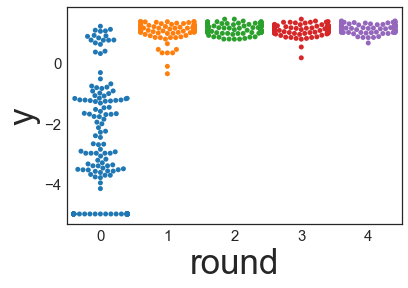

In [34]:
_ = sns.swarmplot(data=df, x='round', y='y')

In [35]:
[max(yy) for yy in y_sampled]

[1.2350148061910993,
 1.3903574303810153,
 1.470634792232138,
 1.470634792232138,
 1.410835623803914]

In [37]:
[opt.get_N(lib, L) for lib in libraries]

[180, 160, 180, 160]